**Импорт библиотек**

In [ ]:
from keras.datasets import mnist
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MiniBatchKMeans
import numpy as np
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from google.colab.patches import cv2_imshow
import cv2
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Кластеризация методом `K-means` для выделения групп объектов

В этой задаче будет рассмотрен метод кластеризации <code>K-means</code> для решения непосредственно задачи кластеризации — задачи выделения схожих структур в данных. Работать будем с известным набором данных <a href="http://yann.lecun.com/exdb/mnist/"><code>MNIST</code></a>.

Загрузим набор данных. Будем использовать только тестовую часть оригинального набора, чтобы сократить время обучения моделей.

In [ ]:
(_,_), (X, y) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Пример вывода нескольких объектов и соответствующих меток классов:

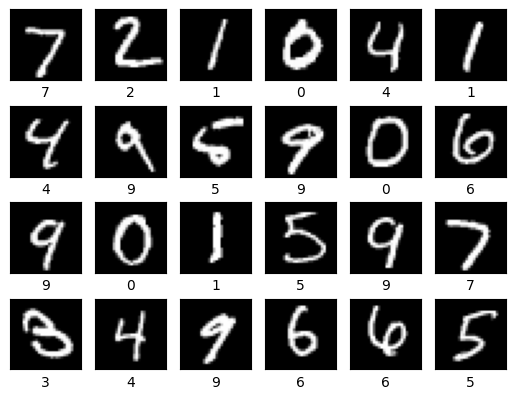

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(X[i], cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_xlabel(y[i], color='black')

Введите <code>.shape</code> полученного набора данных

In [ ]:
X.shape

(10000, 28, 28)

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=7
)

Давайте, раз речь идет об известном наборе данных, заставим <code>K-means</code> искать $10$ групп объектов.

«Распрямите» изображения и обучите алгоритм <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html"><code>KMeans</code></a> с параметрами, указанными в вашем задании.

In [ ]:
X_flat = X_train.reshape(X_train.shape[0], -1).astype('float32') / 255.0  # (8000, 784)
kmeans = KMeans(n_clusters=10, random_state=7)
kmeans.fit(X_flat)

KMeans(n_clusters=10, random_state=7)

Определите число элементов, отнесенных к кластеру, указанному в вашем задании

In [ ]:
target_cluster = 2
labels = kmeans.labels_
count = np.sum(labels == target_cluster)
print(f'Число элементов в кластере {target_cluster}: {count}')

Число элементов в кластере 2: 1186


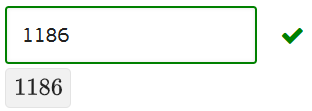

Постройте изображения, соответствующие центроидам полученных кластеров. Для этого `reshape`ните координаты центроидов до размера $28 \times 28$ и постройте полученную матрицу, например, в черно-белых оттенках.



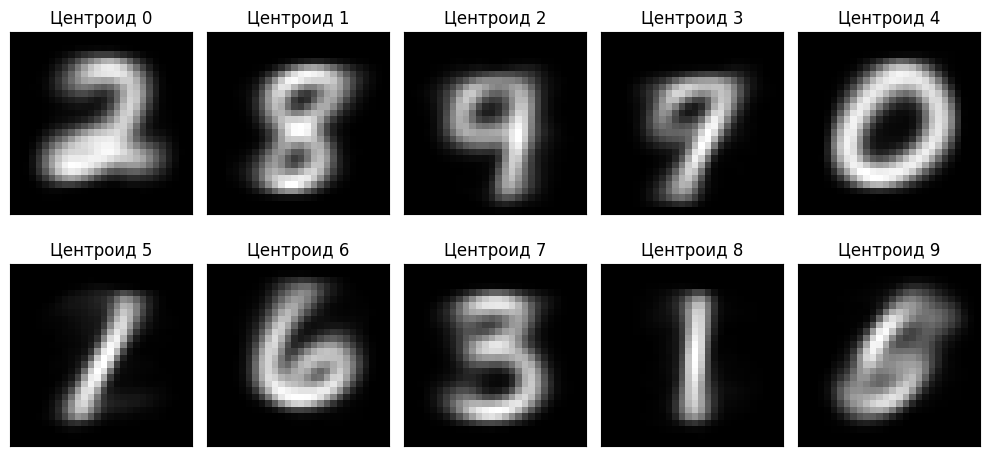

In [ ]:
centroids = kmeans.cluster_centers_  # форма (10, 784)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    # Преобразуем центроид в изображение 28x28
    centroid_image = centroids[i].reshape(28, 28)
    ax.imshow(centroid_image, cmap='gray')
    ax.set_title(f'Центроид {i}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

Можно заметить, что получившиеся картинки весьма походят на рукописные цифры. Впрочем, кластеризация прошла не без накладок.

Так как получившиеся кластеры ничего не знают о природе кластеризумых объектов, метки кластеров могут отличаться от «разумных меток». Восстановите правильные метки, используя следующие соображения: кластеру присваивается метка тех цифр, представителей которых в кластере большинство.

Введите полученные метки кластеров после преобразования и сравните с ранее построенными изображениями на основе центроидов.

In [ ]:
# Создаём mapping: кластер -> истинная цифра
cluster_to_digit = {}

for cluster_id in range(10):
    # Индексы объектов в этом кластере
    mask = (labels == cluster_id)
    true_labels_in_cluster = y_train[mask]

    # Находим наиболее частую цифру
    most_common_digit = mode(true_labels_in_cluster, keepdims=True).mode[0]
    cluster_to_digit[cluster_id] = most_common_digit

# Вывод
for k in range(10):
    print(f'Кластер {k} -> цифра {cluster_to_digit[k]}')

Кластер 0 -> цифра 2
Кластер 1 -> цифра 8
Кластер 2 -> цифра 4
Кластер 3 -> цифра 7
Кластер 4 -> цифра 0
Кластер 5 -> цифра 1
Кластер 6 -> цифра 6
Кластер 7 -> цифра 3
Кластер 8 -> цифра 1
Кластер 9 -> цифра 5


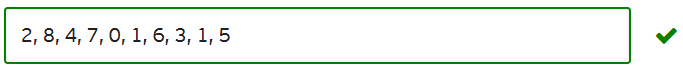

Разумно оценить что-то вроде точности. Считая, что все объекты кластера имеют ту же метку, что и сам кластер, сравните эти метки с истинными метками. Вычислите <code>accuracy</code>. Рекомендуем использовать функцию <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html"><code>accuracy_score</code></a> из библиотеки <code>sklearn</code>.

In [ ]:
y_pred = np.array([cluster_to_digit[label] for label in labels])
acc = accuracy_score(y_train, y_pred)
print(f'Accuracy: {acc:.3f}')

Accuracy: 0.611


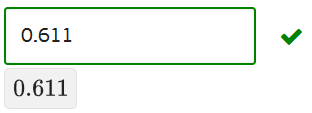

При помощи метода <code>.predict()</code> произведите кластеризацию тестовых данных. Переименуйте метки предсказанных кластеров на основе полученного для тренировочного набора данных преобразования.

In [ ]:
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype('float32') / 255.0
test_cluster_labels = kmeans.predict(X_test_flat)
y_test_pred = np.array([cluster_to_digit[label] for label in test_cluster_labels])

Постройте матрицу ошибок.

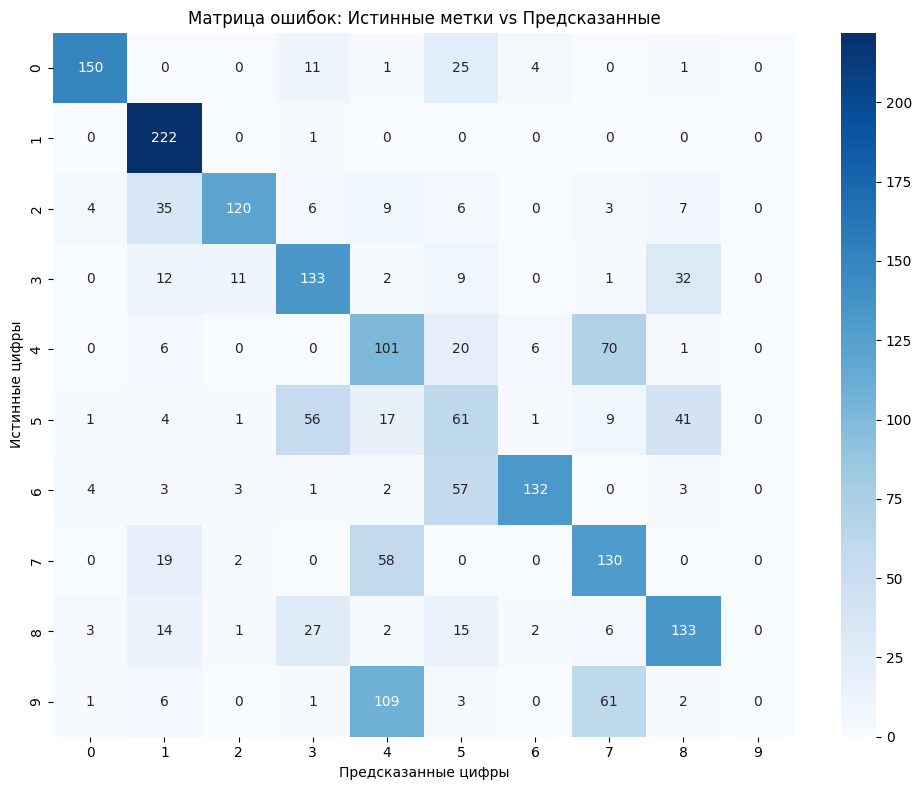

In [ ]:
# Вычисляем матрицу ошибок
cm = confusion_matrix(y_test, y_test_pred, labels=range(10))

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Матрица ошибок: Истинные метки vs Предсказанные')
plt.xlabel('Предсказанные цифры')
plt.ylabel('Истинные цифры')
plt.tight_layout()
plt.show()

С какой цифрой построенная модель чаще всего путала цифру, указанную в вашем варианте?

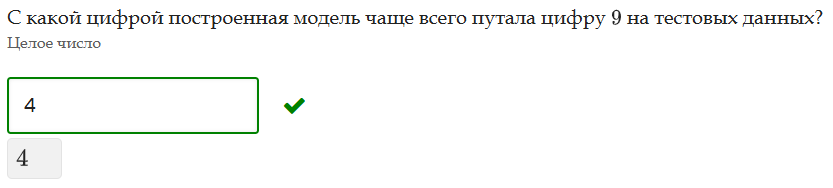

Вычислите точность модели на тестовых данных.

In [ ]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {test_accuracy:.3f}')

Accuracy: 0.591


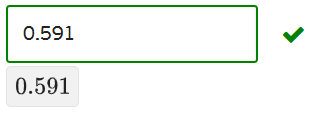

Интересно отметить, что мы построили классификатор на основе кластеризации при том, что никакими «правильными ответами» мы не пользовались (разве что для оценки).

А сколько кластеров кажется оптимальным количеством, если использовать каменистую осыпь? Постройте график каменистой осыпи для числа кластеров от $7$ до $16$. Можно ли уверенно определить оптимальное число кластеров?

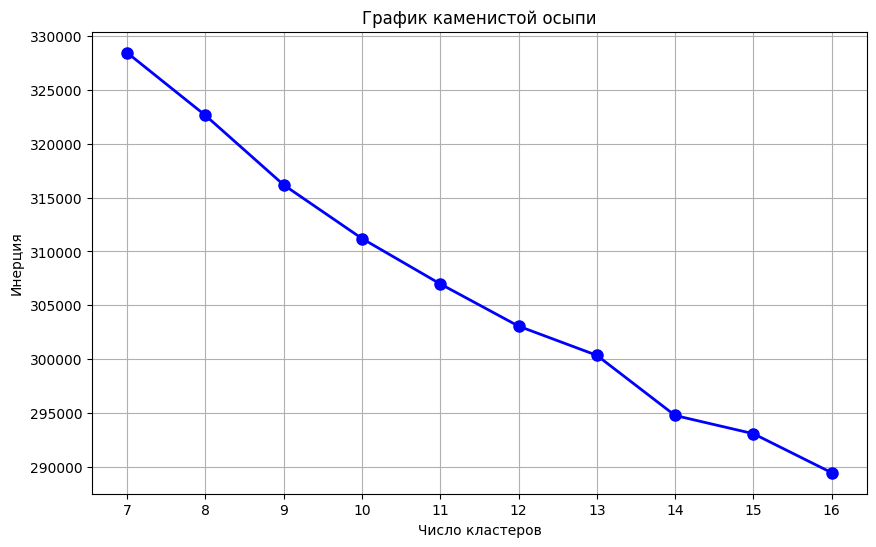

In [ ]:
n_clusters_range = range(7, 17)
inertias = []

for n in n_clusters_range:
    kmeans = KMeans(n_clusters=n, random_state=7)
    kmeans.fit(X_flat)
    inertias.append(kmeans.inertia_)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('График каменистой осыпи')
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.xticks(n_clusters_range)
plt.show()

> На этом графике нет явной точки перегиба, где снижение инерции резко замедляется.

В то же время, еще раз хочется подчеркнуть, как обучение без учителя позволило построить классификатор, который, как будто бы, является результатом решения задачи обучения с учителем.

# Использование `K-means` для сжатия


Еще одно полезное применение кластеризации — сжатие изображений. Схема до удивления проста: похожие, рядом расположенные цвета, стоит объединить в один цвет. Давайте провернем это самостоятельно.

Считайте изображение из вашего индивидуального задания.

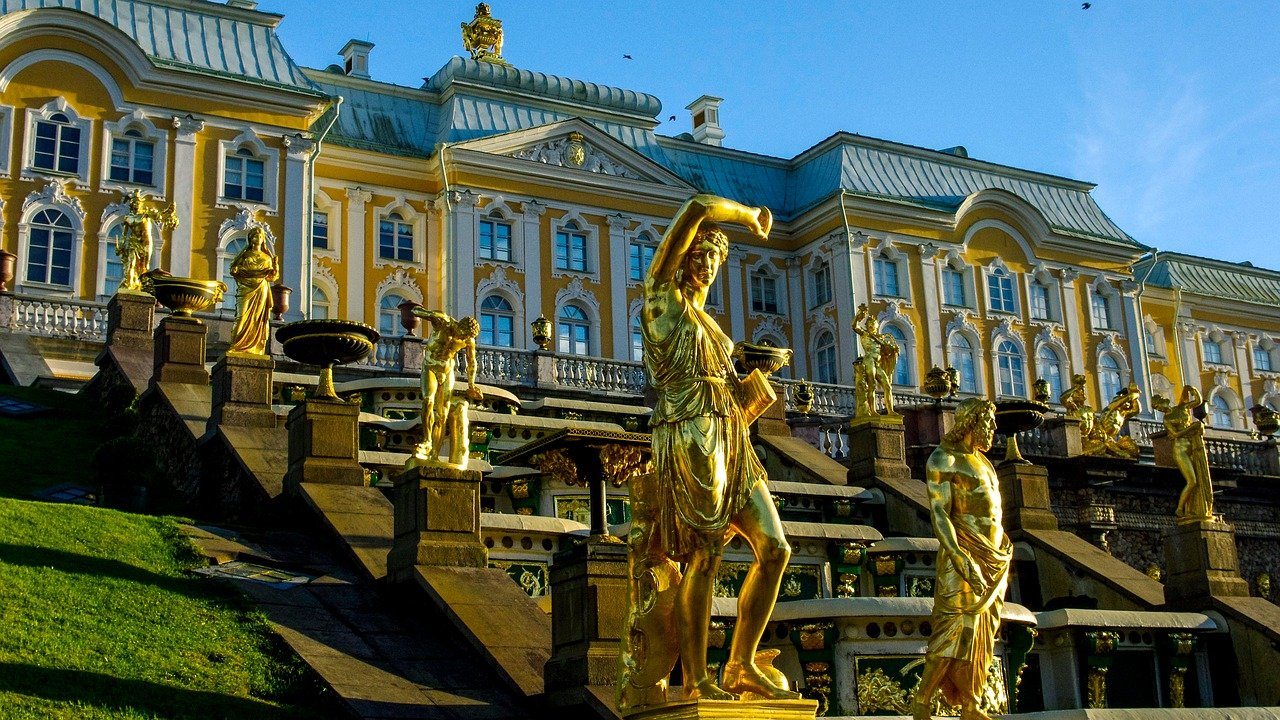

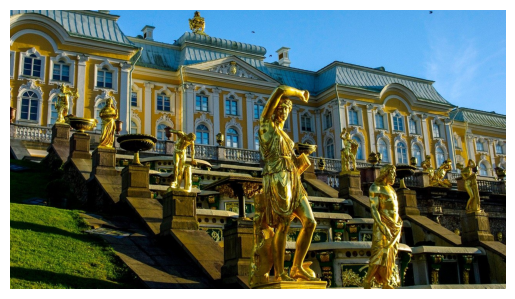

In [ ]:
# Путь к изображению
img_path = 'spb_statues.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)
plt.show()

Перед нами трехканальное (RGB) изображение. Вычислите среднее значение интенсивности пикселей по всем каналам:

In [ ]:
np.mean(img).round(3)

np.float64(84.928)

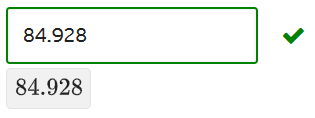

Нормируйте значения интенсивностей пикселей, разделив все значения на $255$. Вычислите среднее значение интенсивности пикселей по всем каналам после проделанного преобразования.

In [ ]:
img_normalized = img / 255.0
np.mean(img_normalized).round(3)

np.float64(0.333)

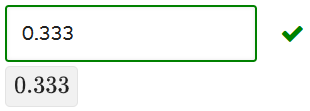

Давайте убедимся в том, что исходное пространство цветов, насчитывающее около $16$ миллионов возможных состояний ($256^3$), слишком велико, и его размерность можно понижать. Для наглядности построим лишь некоторые подвыборки зависимостей значений интенсивностей и лишь на случайном поднаборе пикселей.

«Распрямите» изображение так, чтобы <code>.shape</code> соответствущего массива имел вид <code>(высота * ширина, 3)</code>.

In [ ]:
# Функция принимает на вход "распрямленный" массив, соответствующий изображению

def plot_pixels(data, colors=None, N=10000):
    if colors is None:
        colors = data

    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

In [ ]:
# "Распрямляем" изображение 960×960
img_flat = img_normalized.reshape(-1, 3)
img_flat.shape

(921600, 3)

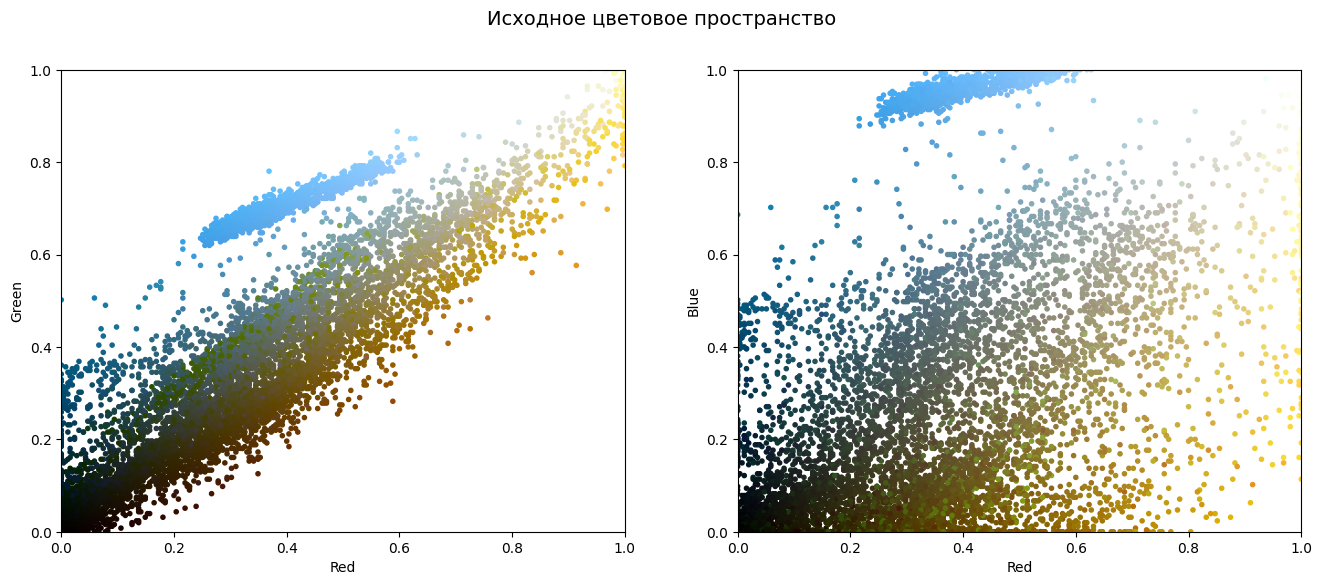

In [ ]:
plot_pixels(img_flat)
plt.suptitle('Исходное цветовое пространство', fontsize=14)
plt.show()

Переведем 16 миллионов возможностей во всего-навсего 16 возможностей, используя <code>K-means</code>. Правда, чтобы ускорить работу алгоритма, мы будем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html"><code>K-means</code> на батчах</a> — поднаборах данных. Заодно увидим, портит ли это результат.

Обучите модель <code>MiniBatchKMeans</code> на нормированном и «распрямленном» изображении с параметрами, указанными в вашем задании.

В изображении замените значения цветов каждого пикселя на значения координат центроида кластера к которому был отнесен этот пиксель. Постройте графики зависимостей цветов при помощи <code>plot_pixels()</code> с новой палитрой (параметр <code>colors</code>).


In [ ]:
# Обучаем MiniBatchKMeans на 16 кластерах
kmeans = MiniBatchKMeans(n_clusters=16, random_state=18)
kmeans.fit(img_flat)

# Получаем метки кластеров для каждого пикселя
labels = kmeans.predict(img_flat)

# Получаем центроиды кластеров (16 цветов)
cluster_centers = kmeans.cluster_centers_

print('Центроиды кластеров (16 цветов):\n')
print(cluster_centers)

Центроиды кластеров (16 цветов):

[[0.51861794 0.45038974 0.13183625]
 [0.48951315 0.58475066 0.60484788]
 [0.10649567 0.11465989 0.06502493]
 [0.61639508 0.58092855 0.39283291]
 [0.50073707 0.75735165 0.97829904]
 [0.3205525  0.35743182 0.30996828]
 [0.25282404 0.208135   0.0310778 ]
 [0.70672691 0.70460325 0.61024158]
 [0.35092817 0.68442334 0.94191997]
 [0.39083988 0.45545977 0.44712484]
 [0.09800097 0.3358541  0.44214174]
 [0.01925899 0.0295489  0.01443787]
 [0.80248686 0.66997871 0.18634027]
 [0.36813692 0.31617199 0.07074052]
 [0.95145029 0.92021667 0.69427123]
 [0.18069047 0.23621261 0.21206056]]


In [ ]:
# Создаём новое изображение, где каждый пиксель - это центроид его кластера
img_compressed = cluster_centers[labels]

# Возвращаем форму изображения
img_compressed_reshaped = img_compressed.reshape(img_normalized.shape)

print(f'Форма сжатого изображения: {img_compressed_reshaped.shape}')

Форма сжатого изображения: (720, 1280, 3)


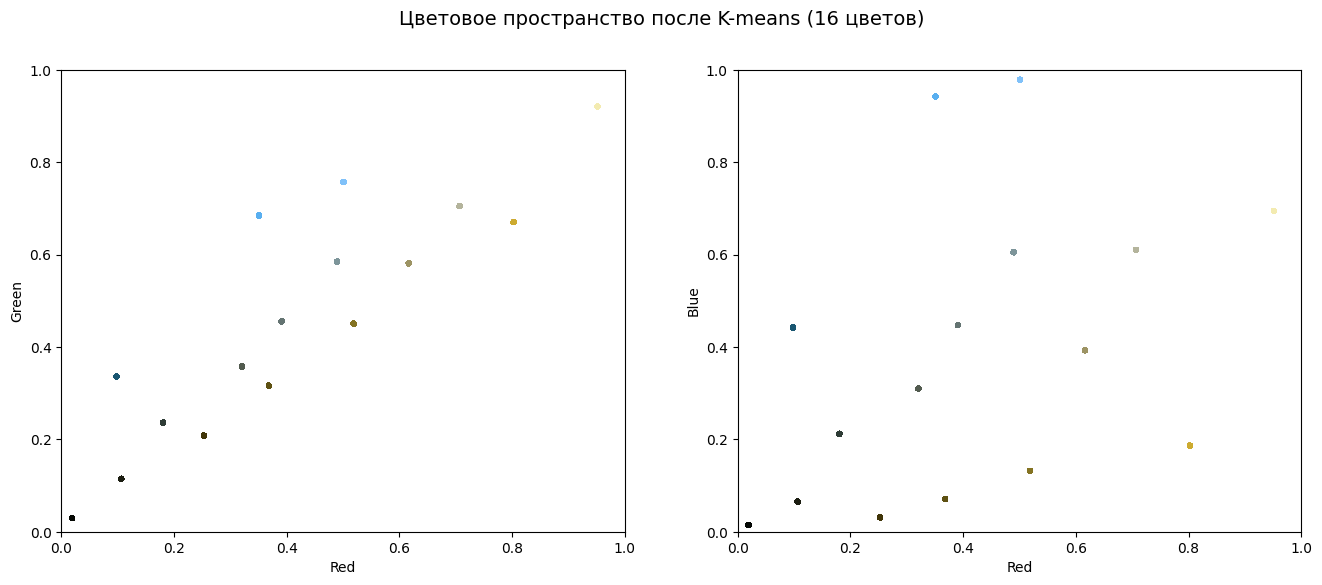

In [ ]:
# Визуализируем сжатое цветовое пространство
plot_pixels(img_compressed, colors=cluster_centers[labels])
plt.suptitle('Цветовое пространство после K-means (16 цветов)', fontsize=14)
plt.show()

Вычислите среднее значение интенсивности пикселей полученного изображения:

In [ ]:
 np.mean(img_compressed_reshaped).round(3)

np.float64(0.333)

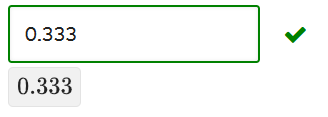

Пора смотреть на результат! Постройте рядом оригинальное изображение и изображение, в котором используется лишь $16$ цветов:

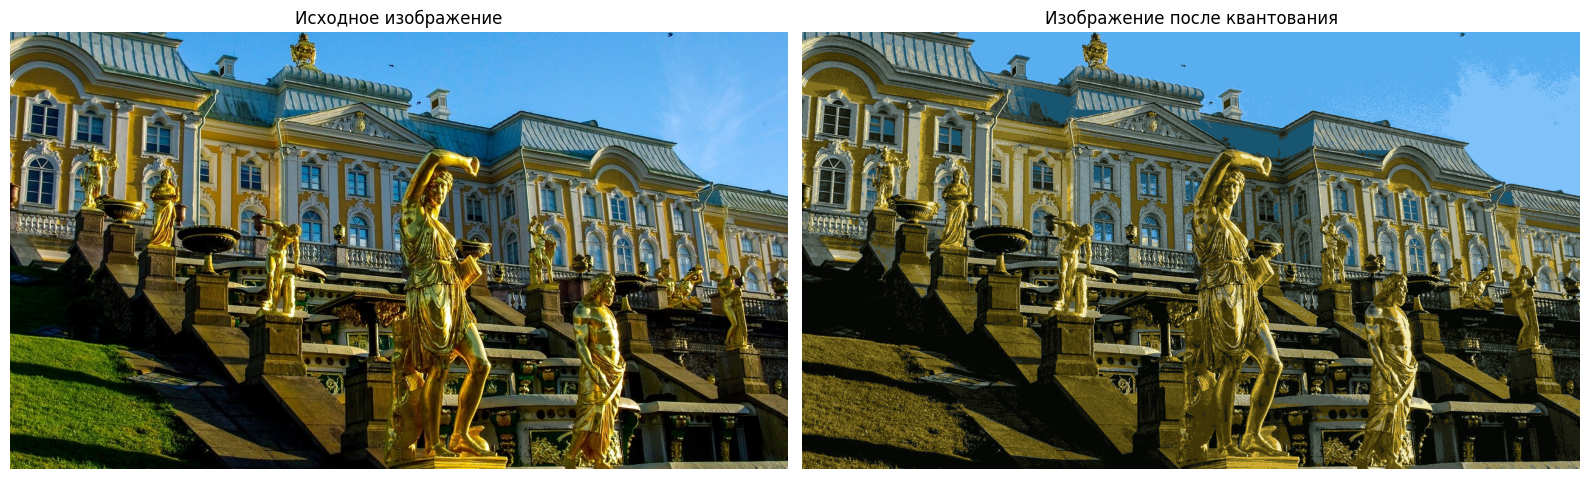

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Исходное изображение
axes[0].imshow(img)
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

# Сжатое изображение
axes[1].imshow(img_compressed_reshaped)
axes[1].set_title('Изображение после квантования')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Что мы видим:

* Все пиксели заменены на один из 16 центроидов, найденных алгоритмом.
* Видна постеризация: градиенты стали ступенчатыми, особенно заметно на небе, тенях и переходах между золотом и фоном.
* Но структура, композиция и основные цвета сохранены.
* Это наглядно демонстрирует, что реально нужных цветов в изображении гораздо меньше, чем 16 миллионов $-$ достаточно 16, чтобы передать суть.

> Квантование цветов $-$ это процесс сокращения количества уникальных цветов в изображении до небольшого фиксированного числа, при этом сохраняя общую визуальную структуру и восприятие.

# Генеративная модель на основе гауссовых смесей

Гауссовы смеси — естественное математическое обобщение алгоритма `K-means`. По сути, подход ищет не просто какие-то кучки вокруг формирующихся центроидов, а некоторую смесь многомерных нормальных распределений (по сути — тоже кучки вокруг средних со своими дисперсиями). Так как такой подход оценивает плотности распределений, то он часто используется в задачах KDE (kernel density estimation). В том числе, он может быть применен к задаче генерации: если есть плотность распределения, то можно семплировать и получать новые объекты. Давайте посмотрим на простейший пример решения такой задачи.

Работать будем опять-таки с `MNIST`. Так как модель оказывается крайне тяжеловесной, будем использовать «простой» набор данных. Визуализируем элементы этого набора данных (для наглядности)

In [ ]:
digits = load_digits()
digits.data.shape

(1797, 64)

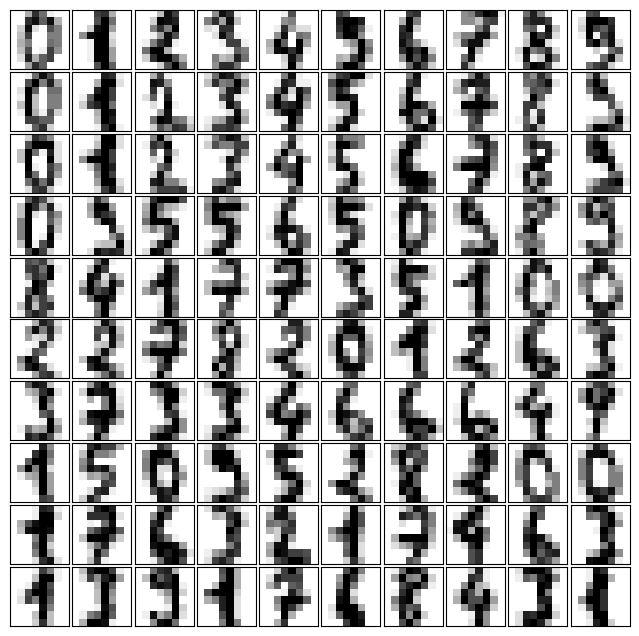

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(8, 8), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
for i, axi in enumerate(ax.flat):
    im = axi.imshow(digits.data[i].reshape(8,8), cmap='binary')
    im.set_clim(0, 16)

Для того, чтобы обучение проходило быстрее имеет смысл снизить размерность пространства признаков. Произведите преобразования для всего набора данных помощи <code>PCA(n_components=0.99, svd_solver=='full')</code>.


In [ ]:
# PCA
pca = PCA(n_components=0.99, svd_solver='full')

# Применяем PCA к данным
digits_pca = pca.fit_transform(digits.data)

Введите число полученных ГК

In [ ]:
print(
    f'Исходное количество признаков:   {digits.data.shape[1]}',
    f'Количество компонент после PCA:  {digits_pca.shape[1]}',
    f'Сохраненная дисперсия:           {pca.explained_variance_ratio_.sum()}',
    sep='\n'
)

Исходное количество признаков:   64
Количество компонент после PCA:  41
Сохраненная дисперсия:           0.9901018242795545


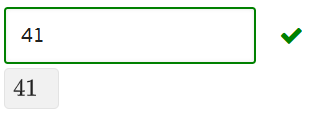

Обучим интересующую нас модель, подобрав гиперпараметр, отвечающий за число используемых компонент, минимизируя <a href="https://ru.wikipedia.org/wiki/Информационный_критерий_Акаике">информационный критерий Акаике</a>.

Для значений параметра <code>n_components</code> в диапазоне $[50,250)$ с шагом $10$ обучите модели <a href="https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html"><code>GaussianMixture</code></a> с параметрами, указанными в вашем задании. При помоши метода <code>.aic()</code> вычислите значение критерия каждой модели.

Введите значение <code>n_components</code> модели с наименьшим значением критерия Акаике.




In [ ]:
best_n = None
best_aic = float('inf')

for n in range(50, 250, 10):
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=7)
    gmm.fit(digits_pca)
    aic = gmm.aic(digits_pca)
    if aic < best_aic:
        best_aic = aic
        best_n = n

print(best_n)

180


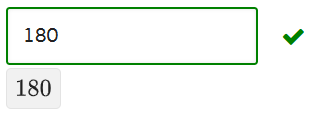

Обучите финальную модель на подобранном гиперпараметре. Проверьте, что обучение сошлось (поле <code>.converged_</code> модели).

In [ ]:
gmm_final = GaussianMixture(n_components=best_n, covariance_type='full', random_state=7)
gmm_final.fit(digits_pca)

# Проверка сходимости
assert gmm_final.converged_

При помощи метода <code>.sample()</code> сгенерируйте $100$ новых объектов.

Введите выборочное среднее коориднаты с индексом $0$ сгенерированных объектов.

In [ ]:
X_sampled, _ = gmm_final.sample(100)
mean_coord_0 = X_sampled[:, 0].mean()
print(mean_coord_0)

-2.991390221296351


При помоши метода <code>.inverse_transform()</code> класса <code>PCA</code> верните сгенерированные объекты в пространство исходных признаков.

In [ ]:
X_sampled_original = pca.inverse_transform(X_sampled)

Визуализируйте полученные результаты. Введите номер изображения, соответствующего сгенерированному объекту с индексом $5$ (индексация начинается с нуля)

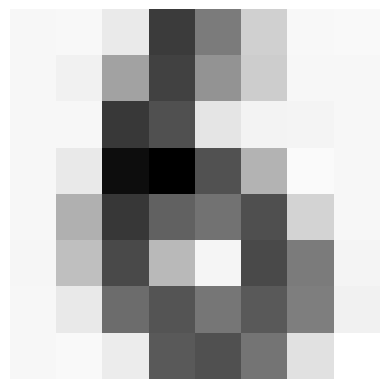

In [ ]:
plt.imshow(X_sampled_original[5].reshape(8, 8), cmap='binary')
plt.axis('off')
plt.show()